# Exploration 노드 9
## 라이브러리 불러오기

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

## 변수 설정

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


## 데이터 준비
데이터를 tf.data를 이용하여 로딩을 한다. 
### 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### 데이터셋 비율 조정

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# train 데이터에 category별 비율 확인
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


### tf.data로 전처리
이미지와 라벨 데이터를 적절한 형식으로 읽어온 후, 모델이 학습할 수 있는 형태(배치)로 만들어준다. 

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [12]:
# test 데이터에 동일 작업
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


우선, augmentation은 과하지 않은 좌우 반전만 되도록 설정하였다. 결과가 좋지 못하다면 이를 빼거나 적절하게 조절할 예정이다. 

In [13]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

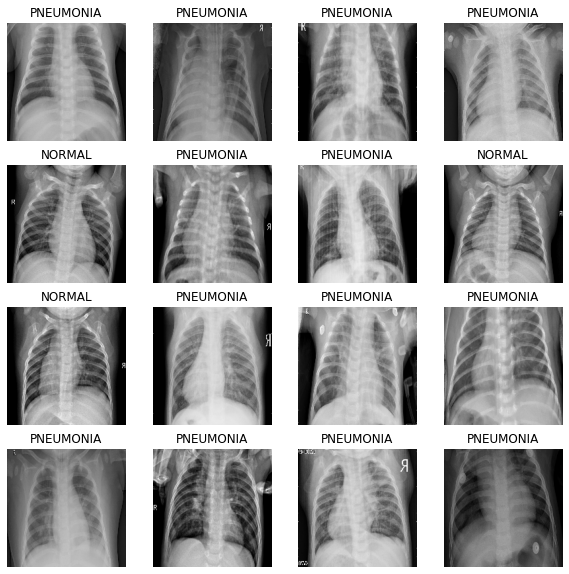

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## 모델 훈련

In [19]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 84s 189ms/step - loss: 0.4026 - accuracy: 0.8029 - precision: 0.9546 - recall: 0.7717 - val_loss: 0.5966 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2468 - accuracy: 0.9059 - precision: 0.9718 - recall: 0.8996 - val_loss: 1.0472 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.2162 - accuracy: 0.9148 - precision: 0.9754 - recall: 0.9082 - val_loss: 0.1375 - val_accuracy: 0.9413 - val_precision: 0.9280 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1809 - accuracy: 0.9330 - precision: 0.9790 - recall: 0.9298 - val_loss: 0.1239 - val_accuracy: 0.9500 - val_precision: 0.9945 - val_recall: 0.9373
Epoch 5/25
261/261 [==============================] - 52s 198ms/step - loss: 0.1783 - accura

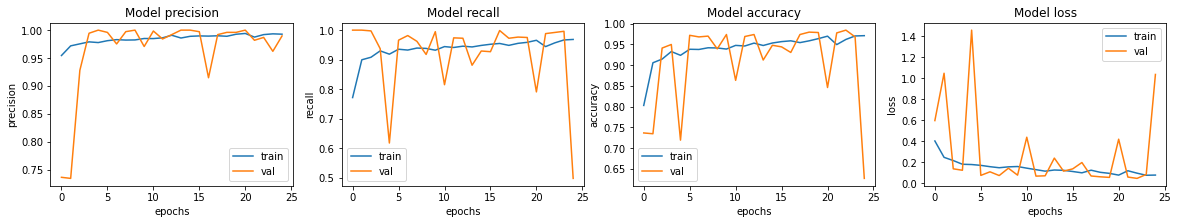

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 111ms/step - loss: 0.7702 - accuracy: 0.7051 - precision: 0.8902 - recall: 0.6026
Loss: 0.7702444195747375,
Accuracy: 0.7051281929016113,
Precision: 0.8901515007019043,
Recall: 0.6025640964508057


결과가 좋지 않아서 augmentation은 빼고 진행하겠다.

## Fine-tuning
### (1) Augmentation 없이 진행 + EarlyStopping
이 경우에 위치 정보가 중요하게 여겨질 수 있기 때문에 데이터 증강하지 않고 다시 진행해본다. 이번엔 콜백함수로 EarlyStopping을 적용한다. 

In [65]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [66]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [67]:
# test 데이터에 동일 작업
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [68]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [69]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [28]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [29]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [30]:
#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
 #                                                   save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=8,
                                                     restore_best_weights=True)

In [31]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [32]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_cb]
    )

Epoch 1/25
261/261 [==============================] - 59s 193ms/step - loss: 0.4045 - accuracy: 0.8089 - precision: 0.9487 - recall: 0.7856 - val_loss: 0.6563 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 50s 190ms/step - loss: 0.2449 - accuracy: 0.8992 - precision: 0.9699 - recall: 0.8921 - val_loss: 1.1048 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1845 - accuracy: 0.9248 - precision: 0.9755 - recall: 0.9221 - val_loss: 0.9856 - val_accuracy: 0.7471 - val_precision: 0.7444 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 192ms/step - loss: 0.1846 - accuracy: 0.9277 - precision: 0.9789 - recall: 0.9229 - val_loss: 0.0855 - val_accuracy: 0.9692 - val_precision: 0.9778 - val_recall: 0.9803
Epoch 5/25
261/261 [==============================] - 51s 194ms/step - loss: 0.1706 - accura

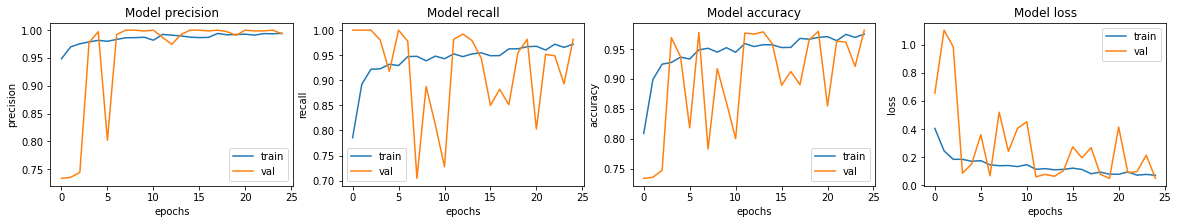

In [33]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [34]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 1.0305 - accuracy: 0.7917 - precision: 0.7529 - recall: 0.9923
Loss: 1.0305054187774658,
Accuracy: 0.7916666865348816,
Precision: 0.7529183030128479,
Recall: 0.9923076629638672


성능 향상이 있었기 때문에 augmentation 없이, EarlyStopping을 계속 사용하겠다.

### Optimizer 변경

Adam의 개선된 버젼이라고 하는 RectifiedAdam(RAdam)을 옵티마이저로 바꾸어서 학습해본다

In [35]:
#checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
 #                                                   save_best_only=True)

EPOCHS=35
    
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=8,
                                                     restore_best_weights=True)

In [36]:
from tensorflow_addons.optimizers import RectifiedAdam
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=RectifiedAdam(),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [37]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_cb]
    )

Epoch 1/35
261/261 [==============================] - 63s 191ms/step - loss: 0.9523 - accuracy: 0.5136 - precision: 0.7608 - recall: 0.5042 - val_loss: 1.7615 - val_accuracy: 0.2644 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/35
261/261 [==============================] - 49s 188ms/step - loss: 0.4459 - accuracy: 0.7651 - precision: 0.9602 - recall: 0.7140 - val_loss: 0.5726 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 49s 187ms/step - loss: 0.3085 - accuracy: 0.8659 - precision: 0.9743 - recall: 0.8418 - val_loss: 0.6504 - val_accuracy: 0.7375 - val_precision: 0.7370 - val_recall: 1.0000
Epoch 4/35
261/261 [==============================] - 49s 188ms/step - loss: 0.2521 - accuracy: 0.8975 - precision: 0.9728 - recall: 0.8871 - val_loss: 0.0919 - val_accuracy: 0.9702 - val_precision: 0.9867 - val_recall: 0.9725
Epoch 5/35
261/261 [==============================] - 50s 192ms/step - loss: 0.2315 

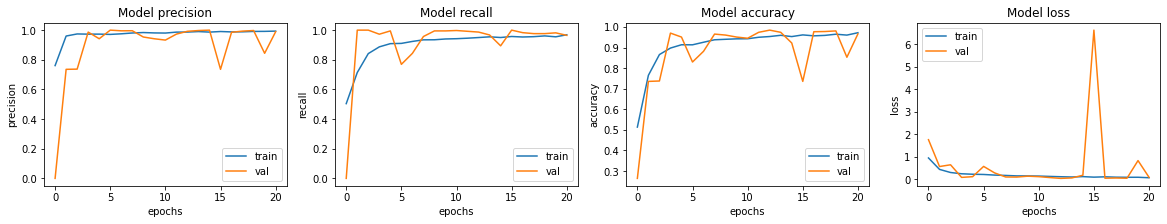

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [39]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 103ms/step - loss: 0.7740 - accuracy: 0.7869 - precision: 0.7466 - recall: 0.9974
Loss: 0.7739978432655334,
Accuracy: 0.7868589758872986,
Precision: 0.7466410994529724,
Recall: 0.9974358677864075


Optimizer는 RAdam이 Adam보다 성능이 낮은 것으로 나와, 다시 Adam을 이용하겠다. 

### (3) 모델의 activation function 변경
Convolution Layer와 Dense Layer의 activation function을 'relu'가 아닌 'swish'로 변경한다. 


In [70]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='swish', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='swish', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [71]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='swish'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [72]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='swish', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='swish', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [73]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=8,
                                                     restore_best_weights=True)

In [74]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [75]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_cb]
    )

Epoch 1/35
261/261 [==============================] - 58s 189ms/step - loss: 0.3890 - accuracy: 0.7996 - precision: 0.9536 - recall: 0.7679 - val_loss: 0.6006 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 49s 188ms/step - loss: 0.2288 - accuracy: 0.9097 - precision: 0.9723 - recall: 0.9043 - val_loss: 0.9538 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 49s 189ms/step - loss: 0.1960 - accuracy: 0.9241 - precision: 0.9723 - recall: 0.9245 - val_loss: 1.8807 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 4/35
261/261 [==============================] - 49s 188ms/step - loss: 0.1786 - accuracy: 0.9344 - precision: 0.9790 - recall: 0.9317 - val_loss: 0.3701 - val_accuracy: 0.8500 - val_precision: 0.9967 - val_recall: 0.7990
Epoch 5/35
261/261 [==============================] - 50s 193ms/step - loss: 0.1393 - accura

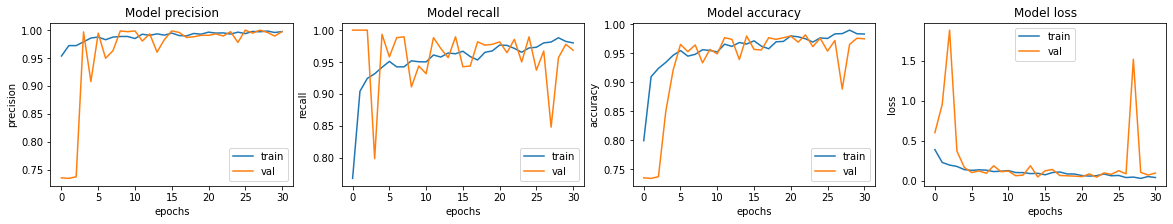

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [77]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 1.2302 - accuracy: 0.7708 - precision: 0.7317 - recall: 1.0000
Loss: 1.230180025100708,
Accuracy: 0.7708333134651184,
Precision: 0.7317073345184326,
Recall: 1.0


swish가 relu보다 낮은 성능을 보여서 다시 relu를 사용하기로 한다. 

### (4) ReduceLROnPlateau 콜백함수 추가

In [88]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [89]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [90]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [91]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=8,
                                                     restore_best_weights=True)
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.0001)

In [92]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [93]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_cb, reduce_lr_cb]
    )

Epoch 1/35
261/261 [==============================] - 56s 182ms/step - loss: 0.4371 - accuracy: 0.8041 - precision: 0.9490 - recall: 0.7787 - val_loss: 0.6339 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 48s 185ms/step - loss: 0.2599 - accuracy: 0.8980 - precision: 0.9718 - recall: 0.8885 - val_loss: 1.0563 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 49s 190ms/step - loss: 0.2244 - accuracy: 0.9145 - precision: 0.9709 - recall: 0.9123 - val_loss: 0.0932 - val_accuracy: 0.9712 - val_precision: 0.9706 - val_recall: 0.9908
Epoch 4/35
261/261 [==============================] - 50s 191ms/step - loss: 0.1934 - accuracy: 0.9296 - precision: 0.9786 - recall: 0.9257 - val_loss: 0.0831 - val_accuracy: 0.9702 - val_precision: 0.9906 - val_recall: 0.9686
Epoch 5/35
261/261 [==============================] - 51s 195ms/step - loss: 0.1799 - accura

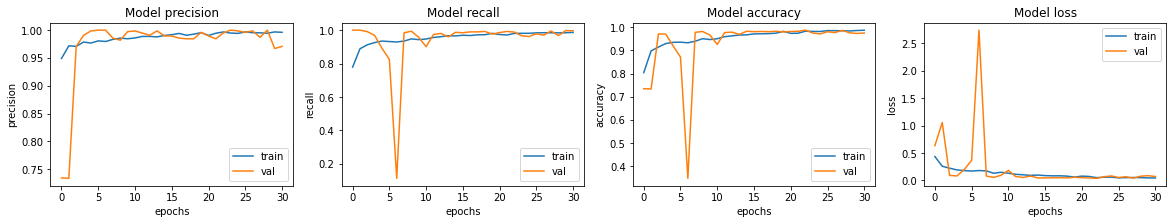

In [94]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [95]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 101ms/step - loss: 0.8628 - accuracy: 0.7804 - precision: 0.7419 - recall: 0.9949
Loss: 0.8628273010253906,
Accuracy: 0.7804487347602844,
Precision: 0.7418738007545471,
Recall: 0.9948717951774597


이 모델은 여러번 돌려보았는데, 전반적으로 더 좋은 성능이 있었기 때문에 이 콜백함수는 앞으로도 이용하겠다. 

### (5) CNN 구조 변경
* Convolution Layer에 kernel_initializer 추가 (he_uniform)
* Convolution block에서 activation function을 batch normalization 이후에 하도록 설정
* patience 5로 조정


In [112]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [113]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [114]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [115]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5,
                                                     restore_best_weights=True)

reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.0001)

In [116]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [117]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_cb, reduce_lr_cb]
    )

Epoch 1/35
261/261 [==============================] - 57s 185ms/step - loss: 0.3503 - accuracy: 0.8429 - precision: 0.9651 - recall: 0.8184 - val_loss: 2.8227 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 48s 185ms/step - loss: 0.2273 - accuracy: 0.9097 - precision: 0.9720 - recall: 0.9047 - val_loss: 2.4428 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 49s 186ms/step - loss: 0.1743 - accuracy: 0.9377 - precision: 0.9804 - recall: 0.9349 - val_loss: 0.1690 - val_accuracy: 0.9375 - val_precision: 0.9235 - val_recall: 0.9974
Epoch 4/35
261/261 [==============================] - 49s 188ms/step - loss: 0.1641 - accuracy: 0.9358 - precision: 0.9827 - recall: 0.9302 - val_loss: 0.0948 - val_accuracy: 0.9635 - val_precision: 0.9620 - val_recall: 0.9896
Epoch 5/35
261/261 [==============================] - 50s 192ms/step - loss: 0.1465 - accura

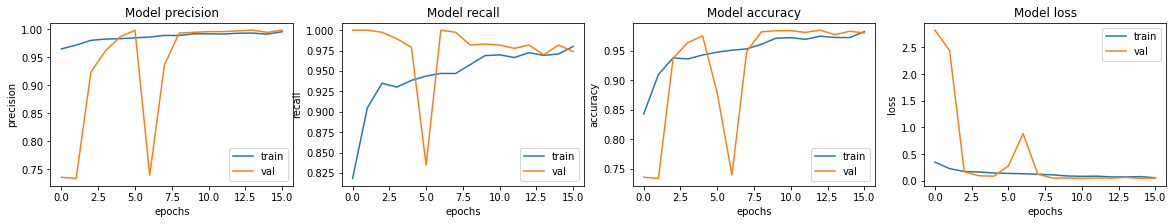

In [118]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [119]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 96ms/step - loss: 0.7633 - accuracy: 0.7901 - precision: 0.7486 - recall: 1.0000
Loss: 0.7633408904075623,
Accuracy: 0.7900640964508057,
Precision: 0.7485604882240295,
Recall: 1.0


### (6) 추가적인 파라미터 바꾸기
* Convolution 단계에서 dropout 제거 
* pooling에 strides 추가 

In [150]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [151]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [152]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [153]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5,
                                                     restore_best_weights=True)

reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.0001)

In [154]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [155]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_cb, reduce_lr_cb]
    )

Epoch 1/35
261/261 [==============================] - 57s 184ms/step - loss: 0.3050 - accuracy: 0.8525 - precision: 0.9691 - recall: 0.8281 - val_loss: 2.4958 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 48s 183ms/step - loss: 0.2010 - accuracy: 0.9265 - precision: 0.9755 - recall: 0.9243 - val_loss: 2.4922 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 48s 183ms/step - loss: 0.1543 - accuracy: 0.9406 - precision: 0.9844 - recall: 0.9350 - val_loss: 0.0633 - val_accuracy: 0.9779 - val_precision: 0.9757 - val_recall: 0.9948
Epoch 4/35
261/261 [==============================] - 47s 179ms/step - loss: 0.1403 - accuracy: 0.9511 - precision: 0.9859 - recall: 0.9479 - val_loss: 0.1057 - val_accuracy: 0.9663 - val_precision: 0.9959 - val_recall: 0.9583
Epoch 5/35
261/261 [==============================] - 49s 188ms/step - loss: 0.1246 - accura

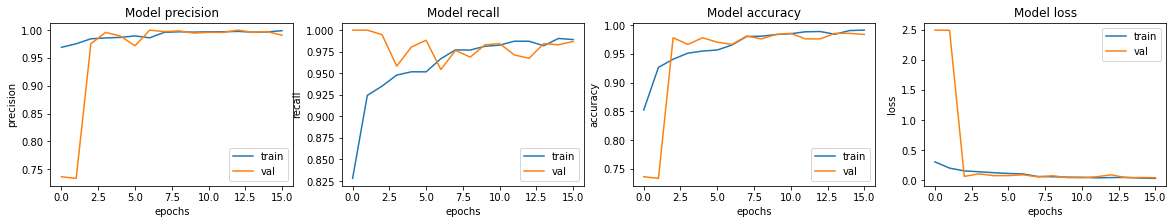

In [156]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [157]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 107ms/step - loss: 0.9207 - accuracy: 0.7676 - precision: 0.7307 - recall: 0.9949
Loss: 0.9206605553627014,
Accuracy: 0.7676281929016113,
Precision: 0.7306967973709106,
Recall: 0.9948717951774597


성능이 낮아져, Pooling Layer의 stride는 다시 디폴트로 변경한다.

### (7) 추가적인 파라미터 바꾸기 2
* Dropout 비율 조정
* ConvLayer kernel 크기 조정
* ConvBlock 2개 제거

In [174]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [175]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [176]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.MaxPool2D(),
        
        #conv_block(32),
        #conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        # 256->128 
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.5),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [177]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5,
                                                     restore_best_weights=True)

reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.0001)

In [178]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [179]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_cb, reduce_lr_cb]
    )

Epoch 1/35
261/261 [==============================] - 58s 187ms/step - loss: 0.2772 - accuracy: 0.8752 - precision: 0.9743 - recall: 0.8548 - val_loss: 3.4535 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 49s 189ms/step - loss: 0.1899 - accuracy: 0.9346 - precision: 0.9794 - recall: 0.9318 - val_loss: 2.5626 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 49s 187ms/step - loss: 0.1445 - accuracy: 0.9454 - precision: 0.9839 - recall: 0.9421 - val_loss: 0.2793 - val_accuracy: 0.8798 - val_precision: 0.8604 - val_recall: 0.9987
Epoch 4/35
261/261 [==============================] - 50s 193ms/step - loss: 0.1326 - accuracy: 0.9507 - precision: 0.9869 - recall: 0.9461 - val_loss: 0.0953 - val_accuracy: 0.9673 - val_precision: 0.9946 - val_recall: 0.9608
Epoch 5/35
261/261 [==============================] - 51s 197ms/step - loss: 0.1264 - accura

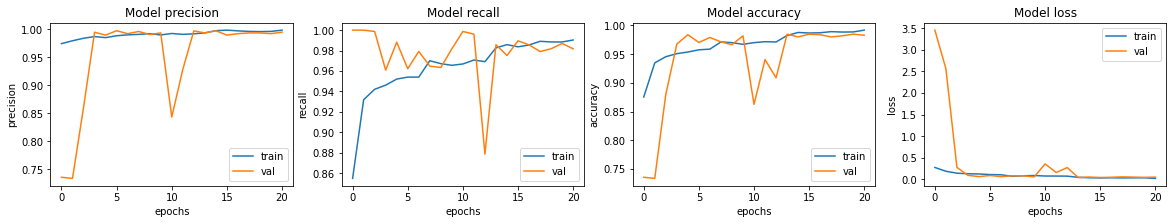

In [180]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [181]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 112ms/step - loss: 1.2442 - accuracy: 0.7452 - precision: 0.7119 - recall: 0.9949
Loss: 1.2442034482955933,
Accuracy: 0.745192289352417,
Precision: 0.7119265794754028,
Recall: 0.9948717951774597


## (8) Conv Layer dropout 다시 제거

In [192]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.SeparableConv2D(filters, 3, padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPool2D()
    ])

    return block

In [193]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [194]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_uniform'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(64),
        conv_block(64),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        conv_block(128),
        #tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(256, 0.5),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [195]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=5,
                                                     restore_best_weights=True)

reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1,
                              patience=3, min_lr=0.0001)

In [196]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [197]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stopping_cb, reduce_lr_cb]
    )

Epoch 1/35
261/261 [==============================] - 58s 187ms/step - loss: 0.3338 - accuracy: 0.8455 - precision: 0.9607 - recall: 0.8260 - val_loss: 2.3403 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/35
261/261 [==============================] - 48s 183ms/step - loss: 0.2240 - accuracy: 0.9183 - precision: 0.9743 - recall: 0.9144 - val_loss: 2.2495 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/35
261/261 [==============================] - 49s 188ms/step - loss: 0.1890 - accuracy: 0.9341 - precision: 0.9749 - recall: 0.9356 - val_loss: 0.0855 - val_accuracy: 0.9769 - val_precision: 0.9806 - val_recall: 0.9883
Epoch 4/35
261/261 [==============================] - 49s 189ms/step - loss: 0.1661 - accuracy: 0.9363 - precision: 0.9804 - recall: 0.9329 - val_loss: 0.3548 - val_accuracy: 0.8788 - val_precision: 0.9893 - val_recall: 0.8446
Epoch 5/35
261/261 [==============================] - 50s 193ms/step - loss: 0.1501 - accura

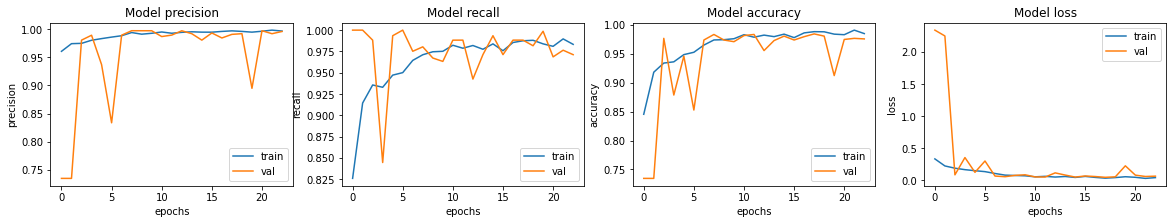

In [198]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [199]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.9858 - accuracy: 0.7532 - precision: 0.7185 - recall: 0.9949
Loss: 0.9857625961303711,
Accuracy: 0.7532051205635071,
Precision: 0.7185184955596924,
Recall: 0.9948717951774597


## 회고
* 결국 기준치인 accuracy 85를 넘기지 못했다.. 분명 방법이 있을텐데 노드를 미루다가 마지막 날에 몰아서 한 내 탓이 크다.. 앞으로 제때 시작해서 더 다양한 시도를 해봐야겠다. 
* 이번에 건드려본 부분들이 옵티마이저, 콜백함수, activation 함수, 모델의 하이퍼파라미터 등이 있는데, 아쉬운 건 각각 한 두 개씩 밖에 바꿔보지 않았다는 것이다. 각각 굉장히 다양한 방법으로 학습을 시도할 수 있는데, 다음에 시간이 날 때 다양하게 실험 해보면서 성능을 높여봐야겠다.
* 시도했던 것 중 하나인 Augmentation은 분명 성능을 높여야될거 같은데 오히려 줄어서 조금 의아했다. 아무래도 저 한번의 학습 때 결과가 잘 나오지 못했던 것 같기도 하고, 더 다양한 방법으로 해봐야 될 것 같기도 하다. 이 부분도 다양한 시도가 필요하다. 
* Accuracy에 가장 큰 영향을 미치는 것은 아무리 봐도 모델의 하이퍼파라미턴다 (kernel 크기, Convolution Layer/Block의 개수 등). 이를 더 조절해보는 것이 Accuracy 높이는 데의 핵심이 될 것이라고 예상이 되는데, 이를 가장 마지막에 바꿔보면서 더 다양한 시도를 할 시간이 없었다는 점이 아쉽다.  
  
  
* 결론: 다음에는 시간을 잘 확보해서 더 다양한 시도들을 많이 해서 루브릭 평가 지표까지 도달하자. 정말 아쉬움만 남는 노드였다.. 